In [5]:
%pip install -U lightgbm==3.3.2
%pip install implicit

     |████████████████████████████████| 2.0 MB 4.3 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


     |████████████████████████████████| 18.5 MB 3.9 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [3]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("/content/drive/MyDrive/HM-new/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [4]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    ItemPair,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
data_dir = Path("/content/drive/MyDrive/HM-new/data/")
model_dir = Path("/content/drive/MyDrive/HM-new/models/")

In [7]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "LargeRecall"
TEST = False # * Set as `False` when do local experiments to save time

In [8]:
TEST_BATCH_SIZE = 70000

In [9]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [10]:
dh = DataHelper(data_dir)

In [11]:
# data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [12]:
data = dh.load_data(name="encoded_full")

In [13]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [ ]:
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']

In [ ]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    last_80day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=80)]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            ALS(customer_list, last_60day, n=200, iter_num=25),
            BPR(customer_list, last_80day, n=200, iter_num=350),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=200, scale=True, name='1'),
            UserGroupTimeHistory(data, customer_list, last_week, ['purchase_ability'], n=200, scale=True, name='2'),
            UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=200, scale=True, name='3'),
            OrderHistory(train, days=35, n=200),
            OrderHistoryDecay(train, days=7, n=200),
            TimeHistory(customer_list, last_week, n=200),

            ItemCF(last_80day, last_2week, top_k=10, name='1'),
            ItemCF(last_60day, last_2week, top_k=10, name='2'),
            ItemCF(last_2week, last_2week, top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'age_bins', top_k=10, name='1'),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
            UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'purchase_ability', top_k=10, name='4'),
            UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
            UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
        ],
        min_pos_rate=0.0,
        norm=False,
        # norm_type='minmax',
        compress=False,
    )

    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )
    rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
    tmp = candidates[rule_names]
    for f in rule_names:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    candidates['score'] = tmp[rule_names].sum(axis=1)
    del tmp
    gc.collect()
    candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
    candidates = candidates[candidates['rank']<=200]
    # del candidates['rank'], candidates['score']

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [ ]:
del train, valid, customer_list, candidates
gc.collect()

44

## Feature engineering


In [22]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [ ]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [ ]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [ ]:
inter.shape

Week Sale, Last Week Sale, Week Sale Trend

In [ ]:
tmp = inter.groupby('customer_id').week.nth(-1)
full_data['consumer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['consumer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['consumer_id_time_mean'] = full_data['customer_id'].map(tmp)

In [ ]:
inter["i_sale"] = week_sale(inter, ["article_id"])
inter["p_sale"] = week_sale(inter, ["product_code"])
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale")
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [01:52<00:00, 18.79s/it]


In [ ]:
_, inter["i_1w_sale_rank"], inter["i_1w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
_, inter["p_1w_sale_rank"], inter["p_1w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_2w_sale"], inter["i_2w_sale_rank"], inter["i_2w_sale_norm"] = period_sale(
    inter, ["article_id"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_2w_sale"], inter["p_2w_sale_rank"], inter["p_2w_sale_norm"] = period_sale(
    inter, ["product_code"], days=14, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_3w_sale"], inter["i_3w_sale_rank"], inter["i_3w_sale_norm"] = period_sale(
    inter, ["article_id"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_3w_sale"], inter["p_3w_sale_rank"], inter["p_3w_sale_norm"] = period_sale(
    inter, ["product_code"], days=21, rank=True, norm=True, week_num=WEEK_NUM
)
inter["i_4w_sale"], inter["i_4w_sale_rank"], inter["i_4w_sale_norm"] = period_sale(
    inter, ["article_id"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)
inter["p_4w_sale"], inter["p_4w_sale_rank"], inter["p_4w_sale_norm"] = period_sale(
    inter, ["product_code"], days=28, rank=True, norm=True, week_num=WEEK_NUM
)

Repurchase Ratio

In [ ]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Popularity

In [ ]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

Already Bought Item

In [ ]:
# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [ ]:
inter.shape

(31788324, 65)

In [ ]:
inter.to_parquet(data_dir / "processed/processed_inter.pqt")

## Merge Features


In [14]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")
# data["inter"] = inter

In [15]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)
# *
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)

In [16]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])

In [17]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    if i == 0:
        chunk_size = int(candidate.shape[0] * 0.5)
        # tmpl = []
        for chunk,batch in enumerate(range(0, candidate.shape[0], chunk_size)):
            sub_candidate = candidate.iloc[batch:batch+chunk_size-1]
            # * merge features
            sub_candidate = merge_week_data(data, inter, i, sub_candidate)
            sub_candidate['article_id'] = sub_candidate['article_id'].astype(int)
            sub_candidate['customer_id'] = sub_candidate['customer_id'].astype(int)
            # * merge DSSM user and item embeddings
            sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
            # * merge YouTubeDNN user and item embeddings
            sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
            print(f"Chunk {chunk} done...")
            # tmpl.append(sub_candidate)
            sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{chunk}.pqt")
    else:
        # * merge features
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
        # * merge W2V user and item embeddings
        candidate["wv_similarity"] = calc_embd_similarity(candidate, w2v_user_embd, w2v_item_embd, sub=False)
    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

  0%|          | 0/6 [00:00<?, ?it/s]

68984
[1 0]



100%|██████████| 1380/1380 [00:06<00:00, 207.15it/s]

100%|██████████| 1380/1380 [00:06<00:00, 225.42it/s]

 33%|███▎      | 2/6 [03:30<07:00, 105.22s/it]

72019
[2 1]



100%|██████████| 1441/1441 [00:06<00:00, 211.22it/s]

100%|██████████| 1441/1441 [00:06<00:00, 217.57it/s]

 50%|█████     | 3/6 [07:15<07:45, 155.22s/it]

75822
[3 2]



100%|██████████| 1517/1517 [00:06<00:00, 228.58it/s]

100%|██████████| 1517/1517 [00:05<00:00, 256.16it/s]

 67%|██████▋   | 4/6 [11:24<06:20, 190.13s/it]

80253
[4 3]



100%|██████████| 1605/1605 [00:08<00:00, 198.48it/s]

100%|██████████| 1605/1605 [00:07<00:00, 209.76it/s]

 83%|████████▎ | 5/6 [15:43<03:34, 214.22s/it]

72035
[4 5]



100%|██████████| 1441/1441 [00:06<00:00, 212.18it/s]

100%|██████████| 1441/1441 [00:06<00:00, 227.41it/s]

100%|██████████| 6/6 [20:45<00:00, 207.56s/it]


In [18]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

53

In [19]:
del candidate

## Ranking


In [14]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    candidates[i] = candidates[i][candidates[i]['rank']<=70]
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

    # weights = {
    #     'ALS_1':1.8,
    #     'BPR_1':1.2,
    #     'OrderHistory_1':1.3,
    #     'UGTimeHistory_1':1.,
    # } # * need to be tuned
    # for f in weights:
    #     candidates[i][f] = candidates[i][f] * weights[f]
    # candidates[i]['score'] = candidates[i][list(weights.keys())].sum(axis=1)

100%|██████████| 5/5 [00:59<00:00, 11.85s/it]


In [15]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "valid",
        # "wv_similarity"
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [16]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:01<00:00, 12.86it/s]


### Extra Features

In [17]:
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

In [18]:
inter = data['inter']
inter = inter[inter['t_dat']<'2020-08-19'] # * start date of the last valid week
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")

In [19]:
tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

In [20]:
tmp = inter.groupby('customer_id').size()
full_data['customer_daily_bought'] = full_data['customer_id'].map(tmp) / full_data['customer_id_gap']

In [21]:
tmp = inter.groupby('customer_id').price.median()
full_data['customer_id_price_median'] = full_data['customer_id'].map(tmp)

In [22]:
full_data['customer_article_price_gap'] = full_data['customer_id_price_median'] - full_data['price']

In [23]:
del tmp
gc.collect()

162

In [24]:
from itertools import chain
def dict_union(L):
    return dict(chain.from_iterable(d.items() for d in L))

dur = [52]
for col in tqdm(["article_id","product_code"]):
    full_data[f'{col}_id_week'] = full_data[col].astype('str') + '_' + full_data['week'].astype('str')

    for j in dur:
        dict_list = []
        for i in range(5):
            tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
            
            tmp['week'] = i+1
            tmp = tmp.groupby(['week', col]).size().reset_index()
            tmp.columns = ['week', col, 'count_sales']

            tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

            dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
            del tmp

        dict_all = dict_union(dict_list)
        full_data[f'{col}_week_shift{j}'] = full_data[f'{col}_id_week'].map(dict_all)

        del dict_all
    gc.collect()

  0%|          | 0/2 [00:00<?, ?it/s]

26

 50%|█████     | 1/2 [00:52<00:52, 52.51s/it]

0

100%|██████████| 2/2 [01:40<00:00, 50.43s/it]


In [25]:
# full_data['article_id_week_1/16'] = full_data['i_sale'] / full_data[f'article_id_week_shift16']
# full_data['article_id_week_1/24'] = full_data['i_sale'] / full_data[f'article_id_week_shift24']
full_data['article_id_week_1/52'] = full_data['i_sale'] / full_data[f'article_id_week_shift52']
# full_data['product_code_week_1/16'] = full_data['i_sale'] / full_data[f'product_code_week_shift16']
# full_data['product_code_week_1/24'] = full_data['i_sale'] / full_data[f'product_code_week_shift24']
full_data['product_code_week_1/52'] = full_data['i_sale'] / full_data[f'product_code_week_shift52']

In [26]:
feats += [
    'article_time_mean', 
    'customer_id_last_time', 
    'customer_id_first_time', 
    'customer_id_time_mean',
    'customer_id_gap',
    'customer_id_price_median',
    'customer_daily_bought',
    'customer_article_price_gap'
] + [f'{col}_week_shift{j}' for col in ["article_id","product_code"] for j in dur] +\
['article_id_week_1/52', 'product_code_week_1/52']

In [27]:
train = full_data.loc[full_data['week']>1]
valid = full_data.loc[full_data['week']==1]

In [28]:
del full_data
gc.collect()

200

In [29]:
# train, _ = reduce_mem_usage(train)
# valid, _ = reduce_mem_usage(valid)

### Train


In [30]:
# for i in tqdm(range(1,WEEK_NUM)):
#     for feat in cat_features:
#         candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])
for feat in tqdm(cat_features):
    train[feat] = train[feat].astype(cate_dict[feat])
    valid[feat] = valid[feat].astype(cate_dict[feat])

100%|██████████| 17/17 [00:23<00:00,  1.38s/it]


In [64]:
params = {
    "objective": "lambdarank",#"lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",#"map",
    "max_depth":8,
    "num_leaves": 128,
    "learning_rate": 0.03,
    # "histogram_pool_size":2048,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [32]:
def train_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_1.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [33]:
def train_binary_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]

    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week


    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [34]:
# for f in feats:
#     for i in range(2,WEEK_NUM):
#         if f not in candidates[i].columns:
#             candidates[i][f] = np.nan

In [35]:
# train = pd.concat([candidates[i] for i in range(2, WEEK_NUM)], ignore_index=True)
# valid = candidates[1]

In [36]:
del candidates
gc.collect()

300

In [37]:
print("Train positive rate:", train.label.mean())

Train positive rate: 0.0050073240743580575


In [38]:
train['customer_id'] = train['customer_id'].astype(int)
train['week_customer_id'] = train['customer_id'].astype(str) + '_' + train['week'].astype(str)
valid_uids = train.groupby('week_customer_id')['label'].sum().reset_index(name='sum')
train = train[train['week_customer_id'].isin(valid_uids.loc[valid_uids['sum'] > 0, 'week_customer_id'])]
del train['week_customer_id']
train['customer_id'] = train['customer_id'].astype(cate_dict['customer_id'])
print("Train positive rate:", train.label.mean())
# 0.013804358075947874

Train positive rate: 0.020538365191982717


In [39]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [40]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
train_group = (train_group.groupby(["week", "customer_id"])["article_id"].count().values)

In [41]:
valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"])["article_id"].count().values

In [42]:
train = train[feats+['label']]
valid = valid[feats+['label']]

In [43]:
gc.collect()

250

In [65]:
ranker = train_model(train, valid, train_group, valid_group) # 0.82846 4-week
# ranker = train_binary_model(train, valid, no=1)
# 0.703171 

# 0.591868
# 0.758603
# 0.760893
# 0.832205

# 0.832311

Training until validation scores don't improve for 30 rounds
[10]	valid_0's map@12: 0.830283
[20]	valid_0's map@12: 0.831343
[30]	valid_0's map@12: 0.83165
[40]	valid_0's map@12: 0.831742
[50]	valid_0's map@12: 0.831766
[60]	valid_0's map@12: 0.83187
[70]	valid_0's map@12: 0.831813
[80]	valid_0's map@12: 0.832078
[90]	valid_0's map@12: 0.832068
[100]	valid_0's map@12: 0.832011
[110]	valid_0's map@12: 0.832157
[120]	valid_0's map@12: 0.832104
[130]	valid_0's map@12: 0.832359
[140]	valid_0's map@12: 0.832285
[150]	valid_0's map@12: 0.832325
[160]	valid_0's map@12: 0.832288
Early stopping, best iteration is:
[131]	valid_0's map@12: 0.832374


### Inference

In [66]:
ranker = lgb.Booster(model_file=model_dir / "lgb_ranker_1.model")

<Figure size 576x1728 with 0 Axes>

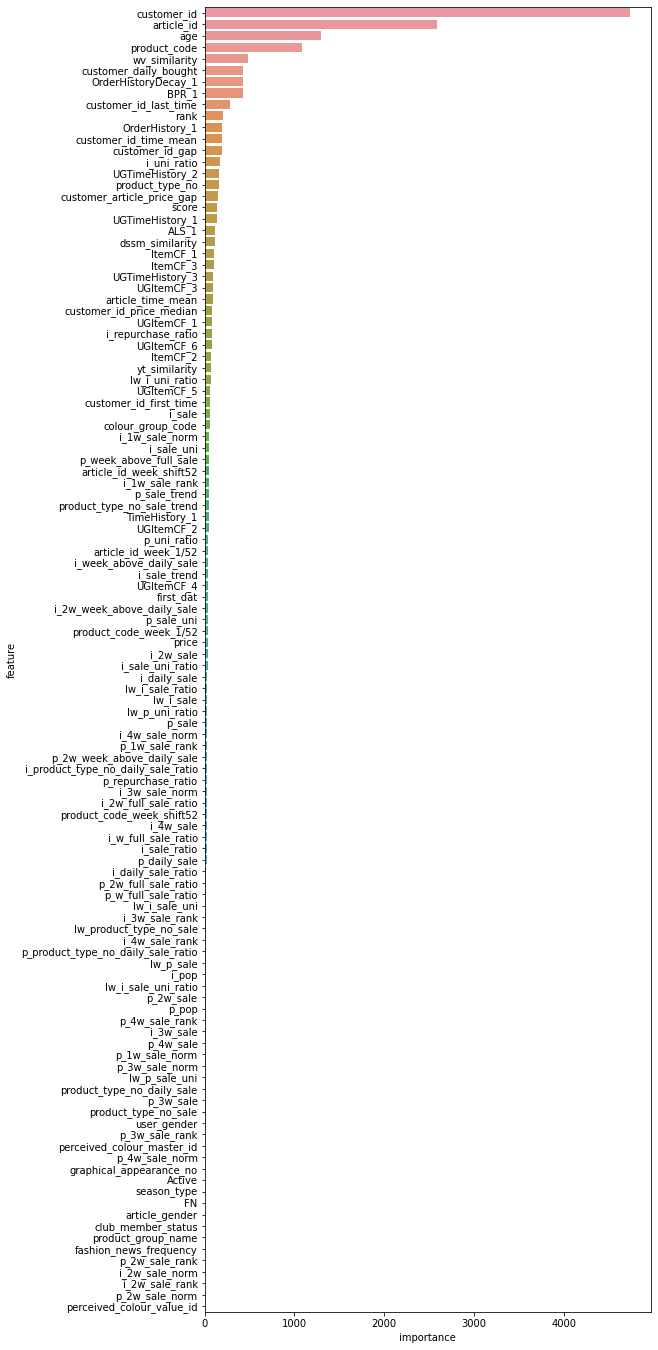

In [67]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 24))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [68]:
val_candidates = valid.reset_index(drop=True)

In [69]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [70]:
pred = predict(ranker, val_candidates)

100%|██████████| 97737/97737 [00:08<00:00, 10957.98it/s]


In [71]:
pred.head()

,customer_id,prediction
0,3,"[96383, 67275]"
1,39,[104451]
2,81,"[104073, 94697, 71108, 67523, 104046, 103109, ..."
3,87,"[100229, 98607, 33869, 27906, 27908, 102711, 1..."
4,108,"[13043, 61306, 61304, 61305, 2220, 53893, 9203..."


In [72]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [73]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week min_pos_rate 0.006 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028694388096248934 4-week min_pos_rate 0.005 lr=0.03
# 0.028927037894290773 4-week min_pos_rate 0.005 lr=0.01
# 0.028936597823123886 4-week min_pos_rate 0.005 lr=0.01 max_depth=9, num_leaves=256

# 0.02184774486112968
# 0.021299757514744458
# 0.024265585916471977

# 0.025168746198396853

# 0.03012106225903273

# 0.029872340663183554

0.02996194449567809

In [74]:
recall_at_k(label["article_id"], label["prediction"], k=44)#0.18282943194751883

0.12430046484891903

### Test

In [ ]:
del val_candidates, candidates
gc.collect()

44

In [ ]:
test_candidates = pd.read_parquet(data_dir/"processed"/VERSION_NAME/"week0_candidate.pqt")
for feat in cat_features:
    test_candidates[feat] = test_candidates[feat].astype(cate_dict[feat])

In [ ]:
test_pred = predict(ranker, test_candidates)

100%|██████████| 1371980/1371980 [01:29<00:00, 15394.20it/s]


In [ ]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [ ]:
def parse(x):
    l = ['0'+str(idx2iid[i]) for i in x]
    l = ' '.join(l[:12])
    return l

In [ ]:
test_pred['prediction'] = test_pred['prediction'].progress_apply(lambda x: parse(x))

100%|██████████| 1371980/1371980 [00:18<00:00, 74629.08it/s]


In [ ]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [ ]:
del submission['prediction']
submission = submission.merge(test_pred, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0779781015 0573085028 0568601043 0918522001 06...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0573085028 0918292001 0448509014 05...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0918522001 0573085028 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0573085028 0918522001 0751471043 0673677002 05...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0927530006 0791587001 0852584001 07...


### Submit

In [ ]:
submit_msg = """
0.028927037894290773 4-week drop
---
OrderHistory(train, days=3, name='1'),
OrderHistory(train, days=7, name='2'),
OrderHistoryDecay(train, days=3, n=50, name='1'),
OrderHistoryDecay(train, days=7, n=50, name='2'),
ItemPair(OrderHistory(train, days=3).retrieve(), name='1'),
ItemPair(OrderHistory(train, days=7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, days=3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, days=7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], days=7, n=50),
TimeHistory(customer_list, last_week, n=50, name='1'),
TimeHistory(customer_list, last_3days, n=50, name='2'),
TimeHistoryDecay(customer_list, train, days=3, n=50, name='1'),
TimeHistoryDecay(customer_list, train, days=7, n=50, name='2'),
SaleTrend(customer_list, train, days=7, n=50)
---
min_pos_rate = 0.005
pivot
"""

In [ ]:
submit_msg

"\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if w

In [ ]:
# ! mkdir ~/.kaggle
# ! cp ../kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# %pip install kaggle

     |████████████████████████████████| 58 kB 3.9 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 5.7 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=2aaa2ba8e16413cb4c49862167277c1d8f29337d273f3f9b02c7f2a0d2b3a357
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f ./submission.csv -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'

100%|████████████████████████████████████████| 258M/258M [00:11<00:00, 22.7MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations